In [1]:
%matplotlib inline

# ToDo :
## Target : ```See the accuracy change within 40 epochs on Discrete convolution```
##  Results :    ```Parameters: 98,960    Accuracy : 74%```
## Analysis : ```4 Convolution layers and 3 MPs indicate that we want to see Edges&Gradients, Textures&Patterns, Parts Of Objects and Objects.```


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Code to check GPU availability

In [4]:
SEED = 1
# Check if CUDA is available
cuda = torch.cuda.is_available()
print("Is CUDA available : ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# Data loader argumens for train and test
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train loader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# Test loader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

Is CUDA available :  True


Let us show some of the training images, for fun.



plane   dog  deer  deer


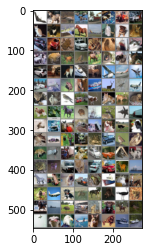

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(16))# Input=32x32x3 Output=32x32x8 RF=3x3
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(32))# Input=16x16x8 Output=16x16x16 RF=8x8
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(64))# Input=8x8x16 Output=8x8x32 RF=18x18
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
                                   nn.ReLU(),
                                  nn.BatchNorm2d(128))# Input=4x4x32 Output=4x4x64 RF=38x38
        self.pool = nn.MaxPool2d(2, 2)
        
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1,1), padding=0, bias=False))

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.conv4(x)
        x = self.gap(x)
        x = self.conv5(x)
        x = x.view(-1, 10)
        return x


net = Net()

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Defaulting to user installation because normal site-packages is not writeable
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,608
              ReLU-6           [-1, 32, 16, 16]               0
       BatchNorm2d-7           [-1, 32, 16, 16]              64
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,432
             ReLU-10             [-1, 64, 8, 8]               0
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        MaxPool2d-12             [-1, 64, 4, 4]               0
           Conv2d-13

Method to Train Model

In [8]:
from tqdm import tqdm

train_losses = []
train_acc = []
def train(model, device, trainloader, optimizer, epoch, reg_type):
    running_loss = 0.0
    correct = 0
    processed = 0
    pbar = tqdm(trainloader)
    for i, data in enumerate(pbar):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update pbar tqdm 
        output = outputs.argmax(dim=1, keepdim=True)
        correct += (output == labels).sum().item()
        processed += len(inputs)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={100*correct/processed:0.2f}')

print('Finished Training')

Finished Training


Method to Test the Model

In [9]:
test_losses = []
test_acc = []
def test(model, device, test_loader, reg_type):
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            test_loss += F.nll_loss(outputs, labels, reduction='sum').item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss)
    print('\nTest Set: Average loss: {}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(testloader.dataset),
                                                                        100. * correct / len(testloader.dataset)))
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print("EPOCH: ", epoch)
    train(net, 'gpu', trainloader, optimizer, epoch, 'l1')
    test(net, 'gpu', testloader, 'l1')
    

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  0


Loss=1.647446870803833 Batch_id=390 Accuracy=1289.32: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -16243.114891052246, Accuracy: 4651/10000 (46.51%)

Accuracy of the network on the 10000 test images: 46 %
EPOCH:  1


Loss=1.4737958908081055 Batch_id=390 Accuracy=1300.16: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -22224.29155731201, Accuracy: 5201/10000 (52.01%)

Accuracy of the network on the 10000 test images: 52 %
EPOCH:  2


Loss=1.3309375047683716 Batch_id=390 Accuracy=1306.04: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -26224.32571029663, Accuracy: 5663/10000 (56.63%)

Accuracy of the network on the 10000 test images: 56 %
EPOCH:  3


Loss=1.1334997415542603 Batch_id=390 Accuracy=1308.93: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -28598.16623687744, Accuracy: 5958/10000 (59.58%)

Accuracy of the network on the 10000 test images: 59 %
EPOCH:  4


Loss=1.000532865524292 Batch_id=390 Accuracy=1311.64: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -31057.035800933838, Accuracy: 6112/10000 (61.12%)

Accuracy of the network on the 10000 test images: 61 %
EPOCH:  5


Loss=1.0828659534454346 Batch_id=390 Accuracy=1312.42: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -33115.74932861328, Accuracy: 6424/10000 (64.24%)

Accuracy of the network on the 10000 test images: 64 %
EPOCH:  6


Loss=0.964846134185791 Batch_id=390 Accuracy=1318.87: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -35409.376331329346, Accuracy: 6515/10000 (65.15%)

Accuracy of the network on the 10000 test images: 65 %
EPOCH:  7


Loss=1.008794903755188 Batch_id=390 Accuracy=1318.83: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -36182.108379364014, Accuracy: 6600/10000 (66.00%)

Accuracy of the network on the 10000 test images: 66 %
EPOCH:  8


Loss=0.917881965637207 Batch_id=390 Accuracy=1321.24: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -38437.250202178955, Accuracy: 6733/10000 (67.33%)

Accuracy of the network on the 10000 test images: 67 %
EPOCH:  9


Loss=0.7725478410720825 Batch_id=390 Accuracy=1321.02: 100%|██████████| 391/391 [00:45<00:00,  8.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -39246.015842437744, Accuracy: 6797/10000 (67.97%)

Accuracy of the network on the 10000 test images: 67 %
EPOCH:  10


Loss=0.909954845905304 Batch_id=390 Accuracy=1322.56: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -40408.578075408936, Accuracy: 6848/10000 (68.48%)

Accuracy of the network on the 10000 test images: 68 %
EPOCH:  11


Loss=0.7460127472877502 Batch_id=390 Accuracy=1322.52: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -41823.86512756348, Accuracy: 6970/10000 (69.70%)

Accuracy of the network on the 10000 test images: 69 %
EPOCH:  12


Loss=0.647110104560852 Batch_id=390 Accuracy=1321.92: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -42795.8371887207, Accuracy: 7010/10000 (70.10%)

Accuracy of the network on the 10000 test images: 70 %
EPOCH:  13


Loss=0.7945884466171265 Batch_id=390 Accuracy=1326.74: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -44103.9628868103, Accuracy: 7094/10000 (70.94%)

Accuracy of the network on the 10000 test images: 70 %
EPOCH:  14


Loss=0.8261297941207886 Batch_id=390 Accuracy=1328.00: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -45256.34378051758, Accuracy: 7144/10000 (71.44%)

Accuracy of the network on the 10000 test images: 71 %
EPOCH:  15


Loss=0.8429722785949707 Batch_id=390 Accuracy=1328.78: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -45299.61268615723, Accuracy: 7140/10000 (71.40%)

Accuracy of the network on the 10000 test images: 71 %
EPOCH:  16


Loss=0.675662636756897 Batch_id=390 Accuracy=1327.26: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -46406.495765686035, Accuracy: 7198/10000 (71.98%)

Accuracy of the network on the 10000 test images: 71 %
EPOCH:  17


Loss=0.8141285181045532 Batch_id=390 Accuracy=1328.18: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -47429.23337554932, Accuracy: 7239/10000 (72.39%)

Accuracy of the network on the 10000 test images: 72 %
EPOCH:  18


Loss=0.7836883664131165 Batch_id=390 Accuracy=1328.05: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -48346.72215270996, Accuracy: 7243/10000 (72.43%)

Accuracy of the network on the 10000 test images: 72 %
EPOCH:  19


Loss=0.48730865120887756 Batch_id=390 Accuracy=1330.51: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -49260.78112792969, Accuracy: 7310/10000 (73.10%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  20


Loss=0.778967022895813 Batch_id=390 Accuracy=1331.97: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -50552.61721801758, Accuracy: 7305/10000 (73.05%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  21


Loss=0.6187278628349304 Batch_id=390 Accuracy=1333.26: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -50758.82476043701, Accuracy: 7325/10000 (73.25%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  22


Loss=0.5793746709823608 Batch_id=390 Accuracy=1329.90: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -51796.44609069824, Accuracy: 7374/10000 (73.74%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  23


Loss=0.5973926186561584 Batch_id=390 Accuracy=1336.25: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -53066.768325805664, Accuracy: 7413/10000 (74.13%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  24


Loss=0.5388506054878235 Batch_id=390 Accuracy=1335.29: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -53437.11573791504, Accuracy: 7362/10000 (73.62%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  25


Loss=0.5790988206863403 Batch_id=390 Accuracy=1335.17: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -53803.55255126953, Accuracy: 7380/10000 (73.80%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  26


Loss=0.639382004737854 Batch_id=390 Accuracy=1336.77: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -54332.62868499756, Accuracy: 7395/10000 (73.95%)

Accuracy of the network on the 10000 test images: 73 %
EPOCH:  27


Loss=0.4814010560512543 Batch_id=390 Accuracy=1335.78: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -54557.89995574951, Accuracy: 7440/10000 (74.40%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  28


Loss=0.5297771096229553 Batch_id=390 Accuracy=1337.99: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -55513.1524810791, Accuracy: 7453/10000 (74.53%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  29


Loss=0.5710960626602173 Batch_id=390 Accuracy=1337.81: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -56716.222663879395, Accuracy: 7463/10000 (74.63%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  30


Loss=0.2611169219017029 Batch_id=390 Accuracy=1337.34: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -57156.13986206055, Accuracy: 7464/10000 (74.64%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  31


Loss=0.529496431350708 Batch_id=390 Accuracy=1341.72: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -57492.415031433105, Accuracy: 7541/10000 (75.41%)

Accuracy of the network on the 10000 test images: 75 %
EPOCH:  32


Loss=0.47258609533309937 Batch_id=390 Accuracy=1337.52: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -58436.70851898193, Accuracy: 7473/10000 (74.73%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  33


Loss=0.32536667585372925 Batch_id=390 Accuracy=1339.67: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -58798.70511627197, Accuracy: 7487/10000 (74.87%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  34


Loss=0.3679574429988861 Batch_id=390 Accuracy=1342.37: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -58334.932052612305, Accuracy: 7405/10000 (74.05%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  35


Loss=0.41949424147605896 Batch_id=390 Accuracy=1339.84: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -59688.526931762695, Accuracy: 7472/10000 (74.72%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  36


Loss=0.3777272701263428 Batch_id=390 Accuracy=1341.42: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -60863.69738769531, Accuracy: 7487/10000 (74.87%)

Accuracy of the network on the 10000 test images: 74 %
EPOCH:  37


Loss=0.5016423463821411 Batch_id=390 Accuracy=1340.94: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -61163.38013458252, Accuracy: 7503/10000 (75.03%)

Accuracy of the network on the 10000 test images: 75 %
EPOCH:  38


Loss=0.44398266077041626 Batch_id=390 Accuracy=1339.76: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Set: Average loss: -62440.27219390869, Accuracy: 7545/10000 (75.45%)

Accuracy of the network on the 10000 test images: 75 %
EPOCH:  39


Loss=0.2674274742603302 Batch_id=390 Accuracy=1345.50: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s] 



Test Set: Average loss: -62281.96817779541, Accuracy: 7530/10000 (75.30%)

Accuracy of the network on the 10000 test images: 75 %


5. We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   frog  ship  deer horse


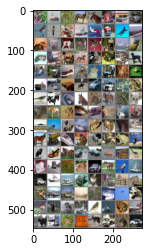

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship  deer horse


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 83 %
Accuracy of  bird : 70 %
Accuracy of   cat : 58 %
Accuracy of  deer : 67 %
Accuracy of   dog : 72 %
Accuracy of  frog : 80 %
Accuracy of horse : 66 %
Accuracy of  ship : 81 %
Accuracy of truck : 84 %
